# TODO  checkout why y does not fit properly and samping fails etc.

In [1]:
#%pip install -i https://test.pypi.org/simple --extra-index-url https://pypi.org/simple tramdag

In [2]:
import os
from tramdag import TramDagModel, TramDagConfig

In [3]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='exp_untrained') # works also without arguments, then default paths are used

Configuration already exists: exp_untrained/configuration.json


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'T':'continous', 
            'x2':'continous',
            'y':'continous'} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
T                    | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
y                    | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at exp_untrained/conf

/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


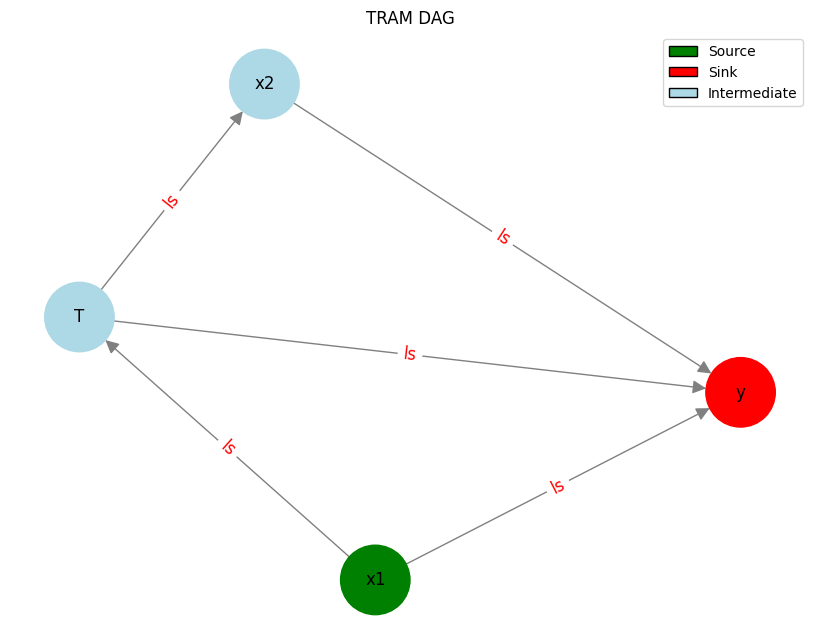

In [5]:
cfg.set_meta_adj_matrix(seed=123) #Create the (Meta) Adjacency Matrix

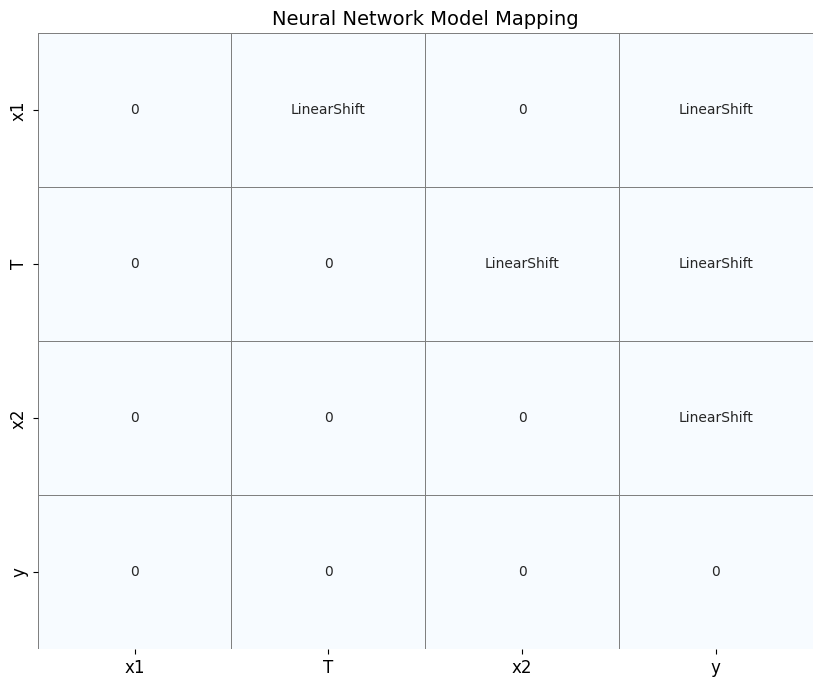

In [6]:
cfg.set_tramdag_nn_models() 
#Create the NN models one per node
# Create names for the models, which then can be to define different architectures for different nodes

All is in the configuration file now, so we delete cfg and load the configuration file

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
np.random.seed(43)
# Ja, sag mal, X1 ist uniform verteilt zwischen 0 und 2.
# T Modelliert als logistische Regression in Abhängigkeit von x1 mit dem Koeffizienten 2. 
# x2 ist normalverteilt mit Mittelwert 0 und Standardabweichung 1.
n = 100
x1 = np.random.uniform(0, 2, size=(n, 1))
T = np.random.binomial(1, 1 / (1 + np.exp(-2 * x1)))
x2 = -1*T + np.random.normal(0,0.1, size=(n, 1))
y = 4*T + 2*x2 + 3*x1 + np.random.normal(0, 0.1, size=(n, 1))
df = pd.DataFrame({'x1': x1.flatten(), 'T': T.flatten(), 'x2': x2.flatten(), 'y': y.flatten()})

print(df.head())


# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

         x1  T        x2         y
0  0.230109  1 -1.002144  2.620235
1  1.218133  1 -0.880834  5.942657
2  0.266782  1 -0.749514  3.341418
3  0.481179  1 -1.133346  3.084941
4  0.654278  1 -1.102827  3.852063


In [8]:
cfg = TramDagConfig.load_json('exp_untrained/configuration.json')
cfg.compute_levels(df=train_df)

In [9]:
from tramdag import TramDagModel
#cfg.compute_levels(train_df) #Calculate the levels from the training file


In [10]:
device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data =train_df )
# Created the model from the configuration
# If weight initialization is set to True then R code like Polar... is used to initialize the weights

In [11]:
# epochs = 50

# td_model.fit(train_df, val_df,
#             #  train_list=['y'], #Training only on a subset of the model
#              learning_rate=1e-2,
#              epochs=epochs,batch_size=1000,
#              verbose=True,debug=False,
#              device=device,
#              num_workers = 8,
#              persistent_workers = True,
#              prefetch_factor = 8,       #For DataLoader
#              train_mode = "sequential") #Parallel is better for many nodes


In [12]:
td_model.plot_loss_history()

[INFO] Loaded training/validation histories for 4 nodes.
[WARNING] No valid histories found to plot.


In [13]:
td_model.plot_linear_shift_history()

[WARNING] No linear shift history found for node 'x1' at exp_untrained/x1/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'T' at exp_untrained/T/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'x2' at exp_untrained/x2/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'y' at exp_untrained/y/linear_shifts_all_epochs.json


In [14]:
td_model.plot_simple_intercepts_history()

[WARNING] No simple intercept history found for node 'x1' at exp_untrained/x1/simple_intercepts_all_epochs.json
[WARNING] No simple intercept history found for node 'T' at exp_untrained/T/simple_intercepts_all_epochs.json
[WARNING] No simple intercept history found for node 'x2' at exp_untrained/x2/simple_intercepts_all_epochs.json
[WARNING] No simple intercept history found for node 'y' at exp_untrained/y/simple_intercepts_all_epochs.json


In [15]:
td_model.load_or_compute_minmax(train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to exp_untrained/min_max_scaling.json


[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[INFO] Final latent DataFrame shape: (80, 8)


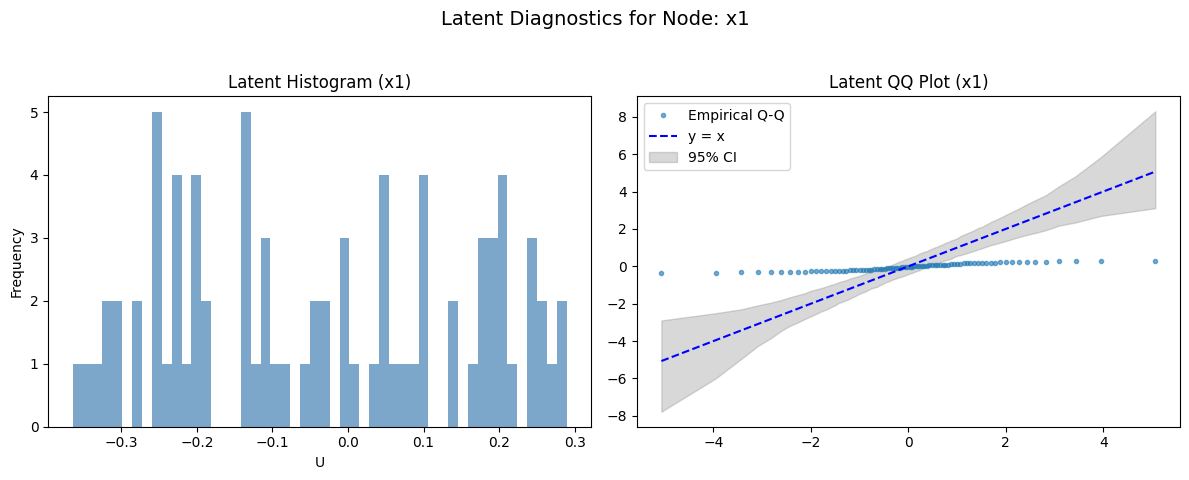

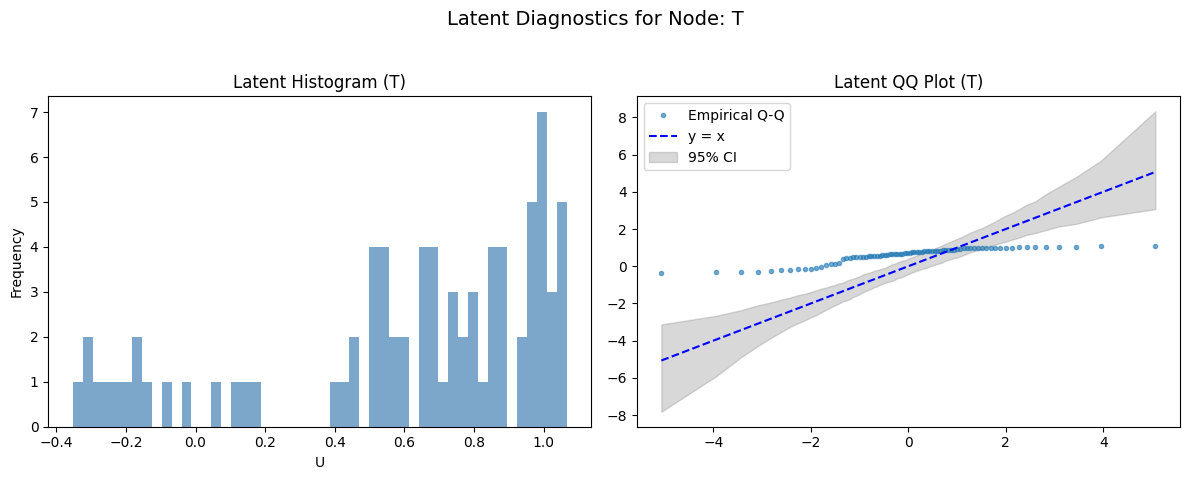

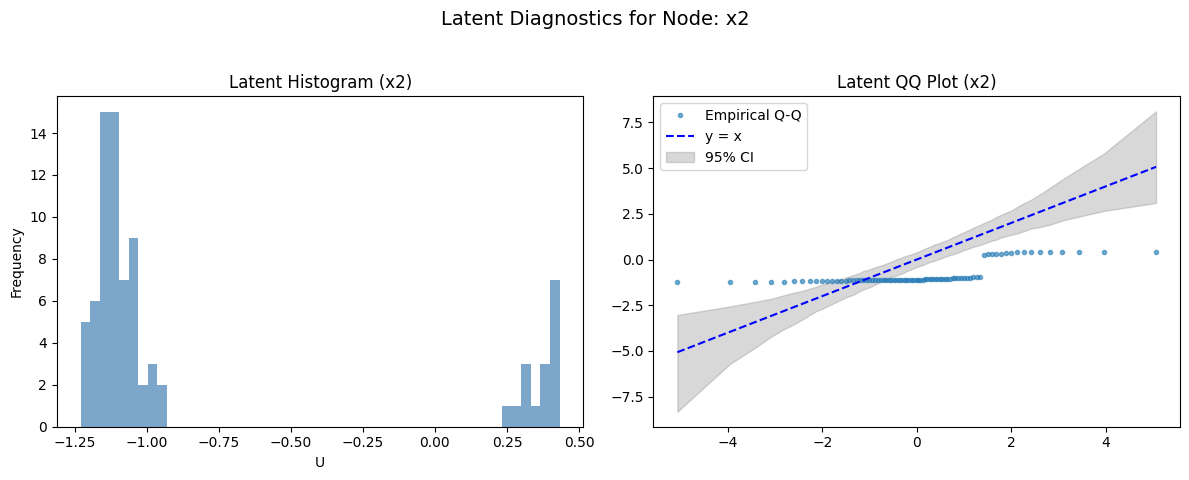

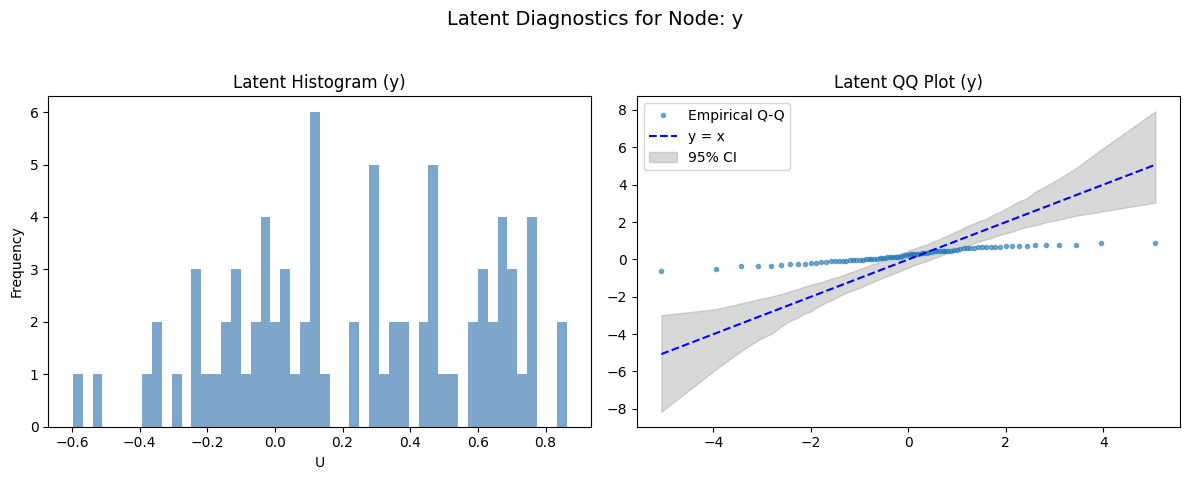

In [16]:
td_model.plot_latents(train_df)

In [17]:
u_training = td_model.get_latent(train_df)

[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[INFO] Final latent DataFrame shape: (80, 8)


In [18]:
samples, latents = td_model.sample(predefined_latent_samples_df=u_training)
#samples, latents = td_model.sample()

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 80
[INFO] Deleting all previously sampled data.
Deleted directory: exp_untrained/x1/sampling
Deleted directory: exp_untrained/T/sampling
Deleted directory: exp_untrained/x2/sampling
Deleted directory: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U
[WARNING] Best model not found for node 'x1'. Using initial weights instead.
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 738.28it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node T from dataframe column: T_U
[WARNING] Best model not found for node 'T'. Using initial weights instead.
[WARNING] target_col 'T' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 769.08it/s]

[INFO] Completed sampling for node 'T'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U
[WARNING] Best model not found for node 'x2'. Using initial weights instead.
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 790.84it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U
[WARNING] Best model not found for node 'y'. Using initial weights instead.
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 872.59it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


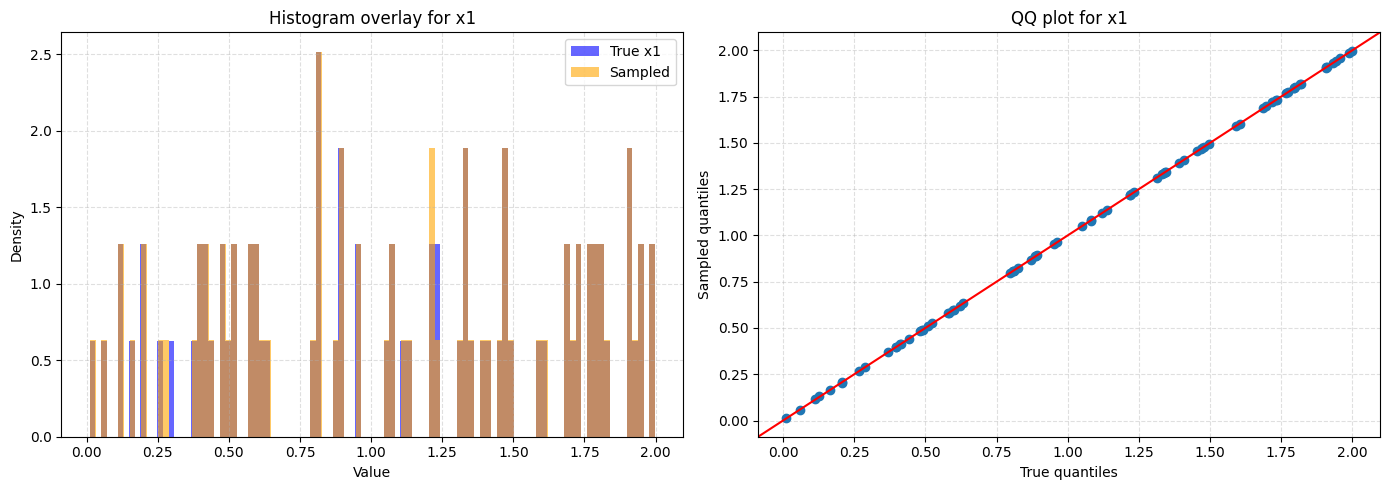

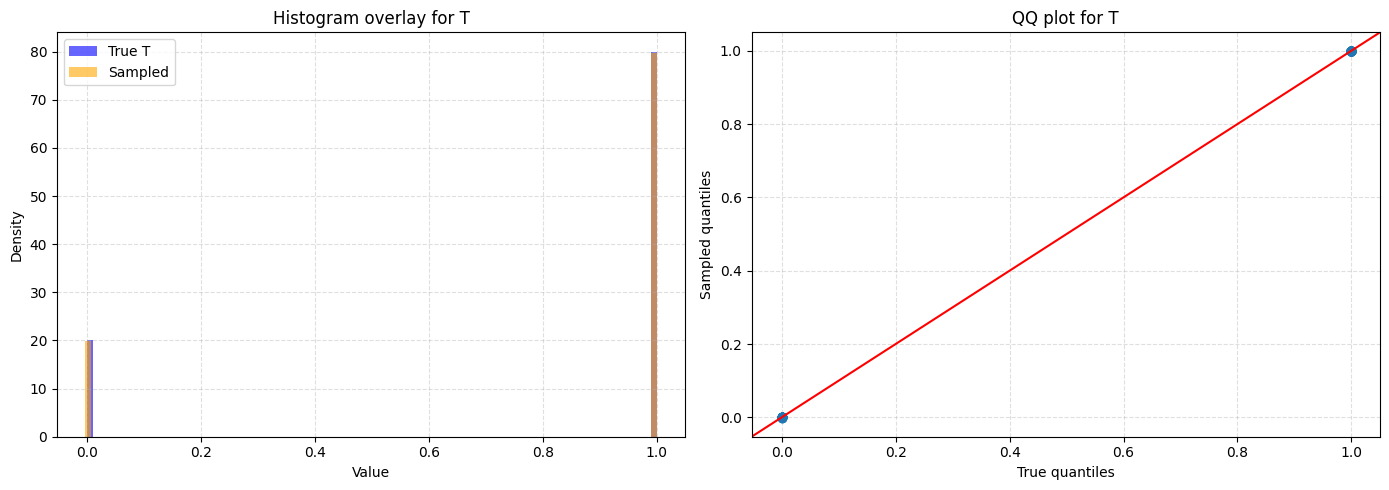

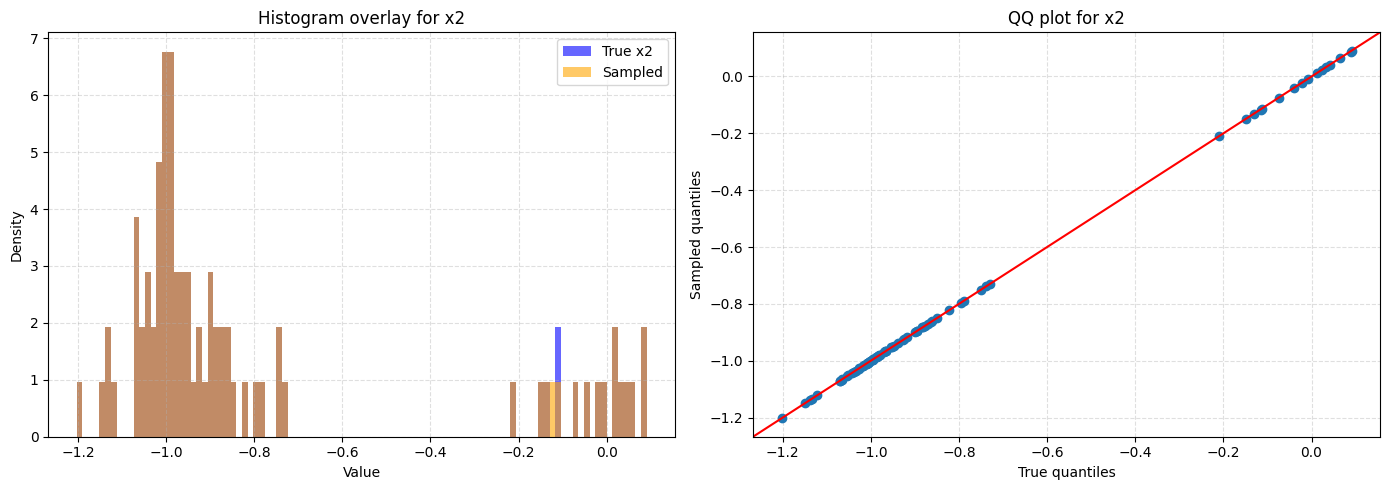

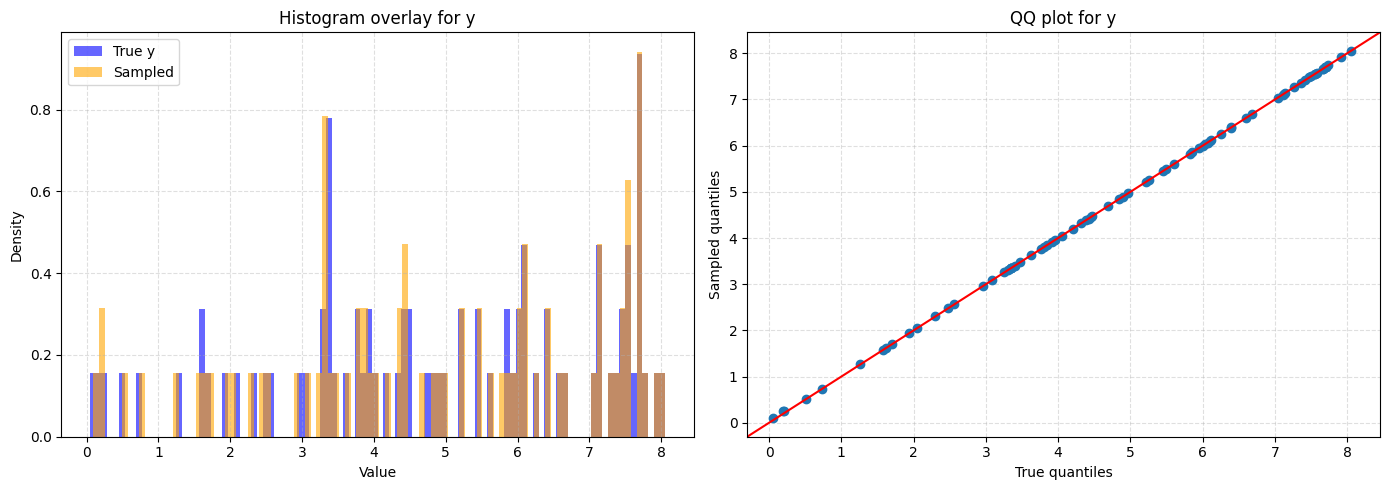

In [19]:
td_model.plot_samples_vs_true(df=train_df, sampled=samples)

[WARNING] len(df)>1, set: plot_n_rows accordingly
[Warning] best_model.pt not found, falling back to initial_model.pt

=== Sample 1/1 ===
x1    0.798394
T     0.000000
x2   -0.149715
y     2.052128
Name: 55, dtype: float64


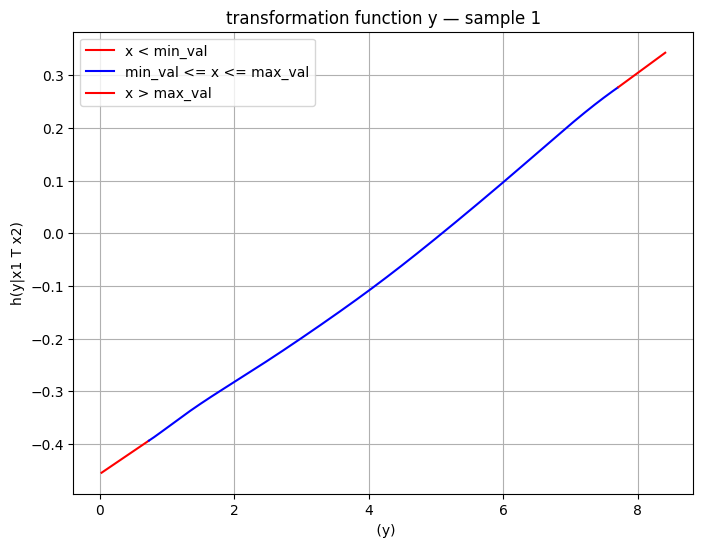

In [20]:
td_model.plot_hdag(train_df,variables=['y'],plot_n_rows=1)

In [31]:
td_model.nll(val_df)

{'x1': 2.439948558807373,
 'T': 1.5006203651428223,
 'x2': 1.963209867477417,
 'y': 3.6952061653137207}

In [32]:
td_model.nll(train_df)

{'x1': 2.463045120239258,
 'T': 1.5253733396530151,
 'x2': 2.051924705505371,
 'y': 3.7330527305603027}

In [22]:
td_model.summary(verbose=False)


                                                 TRAM DAG MODEL SUMMARY                                                 

[1] TRAINING METRICS OVERVIEW
------------------------------------------------------------------------------------------------------------------------
     Node      Best Train NLL  Best Val NLL  Last Train NLL  Last Val NLL      Epochs    
      x1            None           None           None           None            0       
       T            None           None           None           None            0       
      x2            None           None           None           None            0       
       y            None           None           None           None            0       
------------------------------------------------------------------------------------------------------------------------

[2] NODE-SPECIFIC DETAILS
------------------------------------------------------------------------------------------------------------------------

      

In [23]:
############### !!!!!!!!!!!!!!!!!!!!!!!!! #######################################################
u_training = td_model.get_latent(train_df)
samples_doT1, latents_doT1 = td_model.sample(do_interventions={'T':1.0}, predefined_latent_samples_df=u_training)
#################################################################################################

[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[Warning] best_model.pt not found, falling back to initial_model.pt
[INFO] Final latent DataFrame shape: (80, 8)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['T']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 80
[INFO] Deleting all previously sampled data.
Deleted directory: exp_untrained/x1/sampling
Deleted directory: exp_untrained/T/sampling
Deleted directory: exp_untrained/x2/sampling
Deleted directory: exp_untrained/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U
[WARNING] Best model not found f

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 894.61it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: T ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'T' with value 1.0
[INFO] Interventional data for node T is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U
[WARNING] Best model not found for node 'x2'. Using initial weights instead.
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 900.96it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node y from dataframe column: y_U
[WARNING] Best model not found for node 'y'. Using initial weights instead.
[WARNING] target_col 'y' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 946.50it/s]

[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


$$
u2 = h(x2|T=1)
$$

$$
x2 = h^{-1}(u2|T=1)
$$

$$
x2 = h^{-1}(h(x2|T=1)|T=1)
$$


$$
uy = h(y|T=1, x1,x2) \\
y = h^{-1}(uy|T=1, x1,x2) \\
y = h^{-1}(h(y|T=1, x1,x2)|T=1, x1,x2)

$$

In [24]:
# Create a data frame from samples_doT1
samples_doT1_df = pd.DataFrame(samples_doT1)
print(samples_doT1_df.shape)
samples_doT1_df.head()
# Sahpe of samples_doT1_df
samples_doT1_df.shape, train_df.shape

# Extract the rows where T=1 from train_df and samples_doT1_df
mask = train_df['T'] == 1
train_with_T1 = train_df[mask]
samples_doT1_with_T1 = samples_doT1_df[mask.values]

train_with_T1.shape, samples_doT1_with_T1.shape
np.sum(train_with_T1['T'] == 1)
samples_doT1_with_T1['T']

(80, 4)


3     1.0
5     1.0
6     1.0
7     1.0
8     1.0
     ... 
74    1.0
76    1.0
77    1.0
78    1.0
79    1.0
Name: T, Length: 64, dtype: float32

In [25]:
np.mean(train_with_T1['T'] > 0.5)
samples_doT1_with_T1


,x1,T,x2,y
3,1.730032,1.0,-1.018675,7.104980
5,0.442061,1.0,-0.924694,3.472002
6,1.906080,1.0,-0.986978,7.708780
7,1.771797,1.0,-0.983353,7.478248
8,1.467496,1.0,-1.027426,6.391068
...,...,...,...,...
74,1.697876,1.0,-0.738255,7.575866
76,0.490690,1.0,-1.008968,3.400405
77,1.733295,1.0,-0.822560,7.365582
78,1.908639,1.0,-0.994328,7.739513


In [26]:
train_with_T1['T']

42    1
15    1
40    1
96    1
9     1
     ..
20    1
71    1
14    1
92    1
51    1
Name: T, Length: 64, dtype: int64

In [27]:
import matplotlib.pyplot as plt

(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

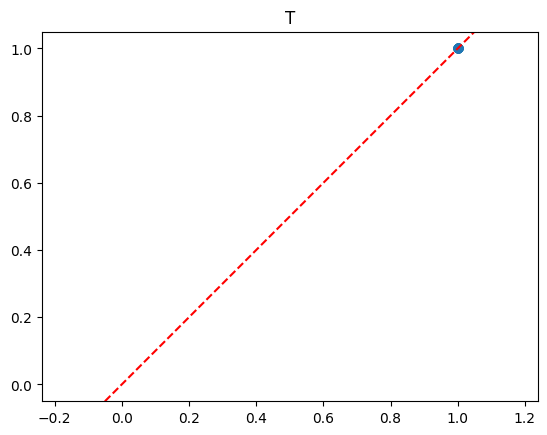

In [28]:
plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')

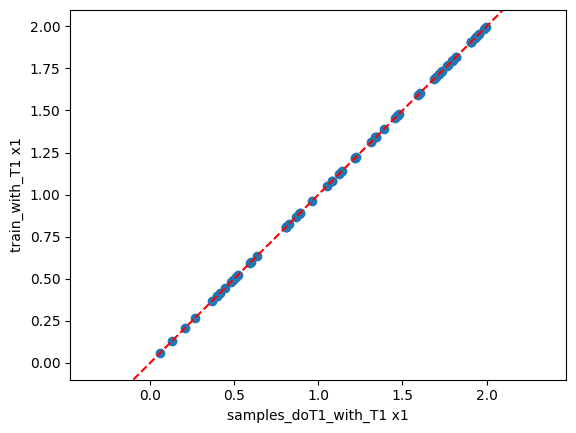

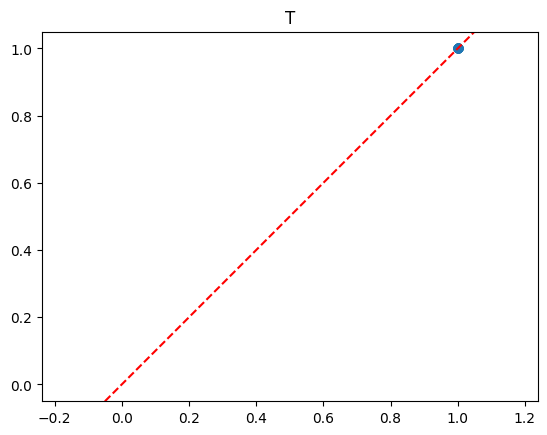

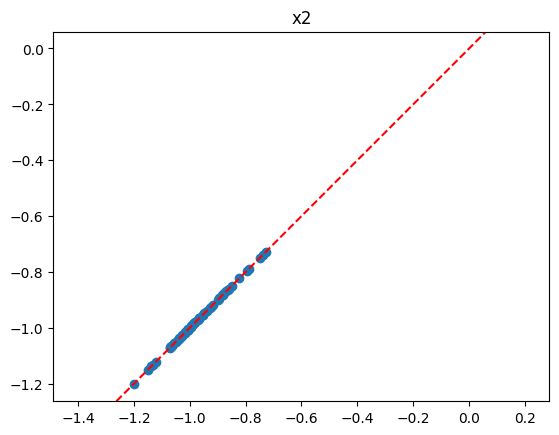

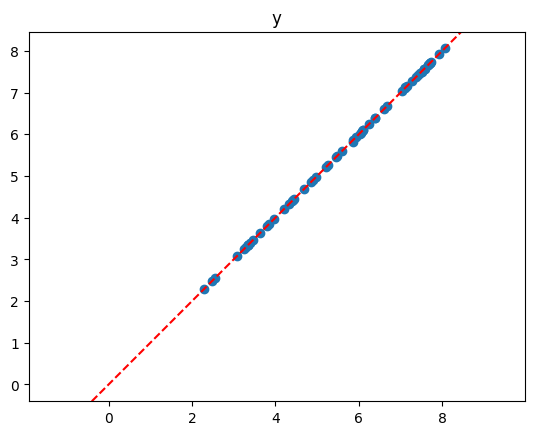

In [29]:
from matplotlib import pyplot as plt

plt.scatter(samples_doT1_with_T1['x1'], train_with_T1['x1'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.xlabel('samples_doT1_with_T1 x1')
plt.ylabel('train_with_T1 x1')
plt.show()


plt.scatter(train_with_T1['T'], train_with_T1['T'])
plt.title('T')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('x2')
plt.scatter(samples_doT1_with_T1['x2'], train_with_T1['x2'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()

plt.title('y')
plt.scatter(samples_doT1_with_T1['y'], train_with_T1['y'])
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.axis('equal')
plt.show()



In [30]:
## TODO 
# n data trained
#  Train NLL
# td_model.nll(train_df)
# coefficient LS SI , 

#  

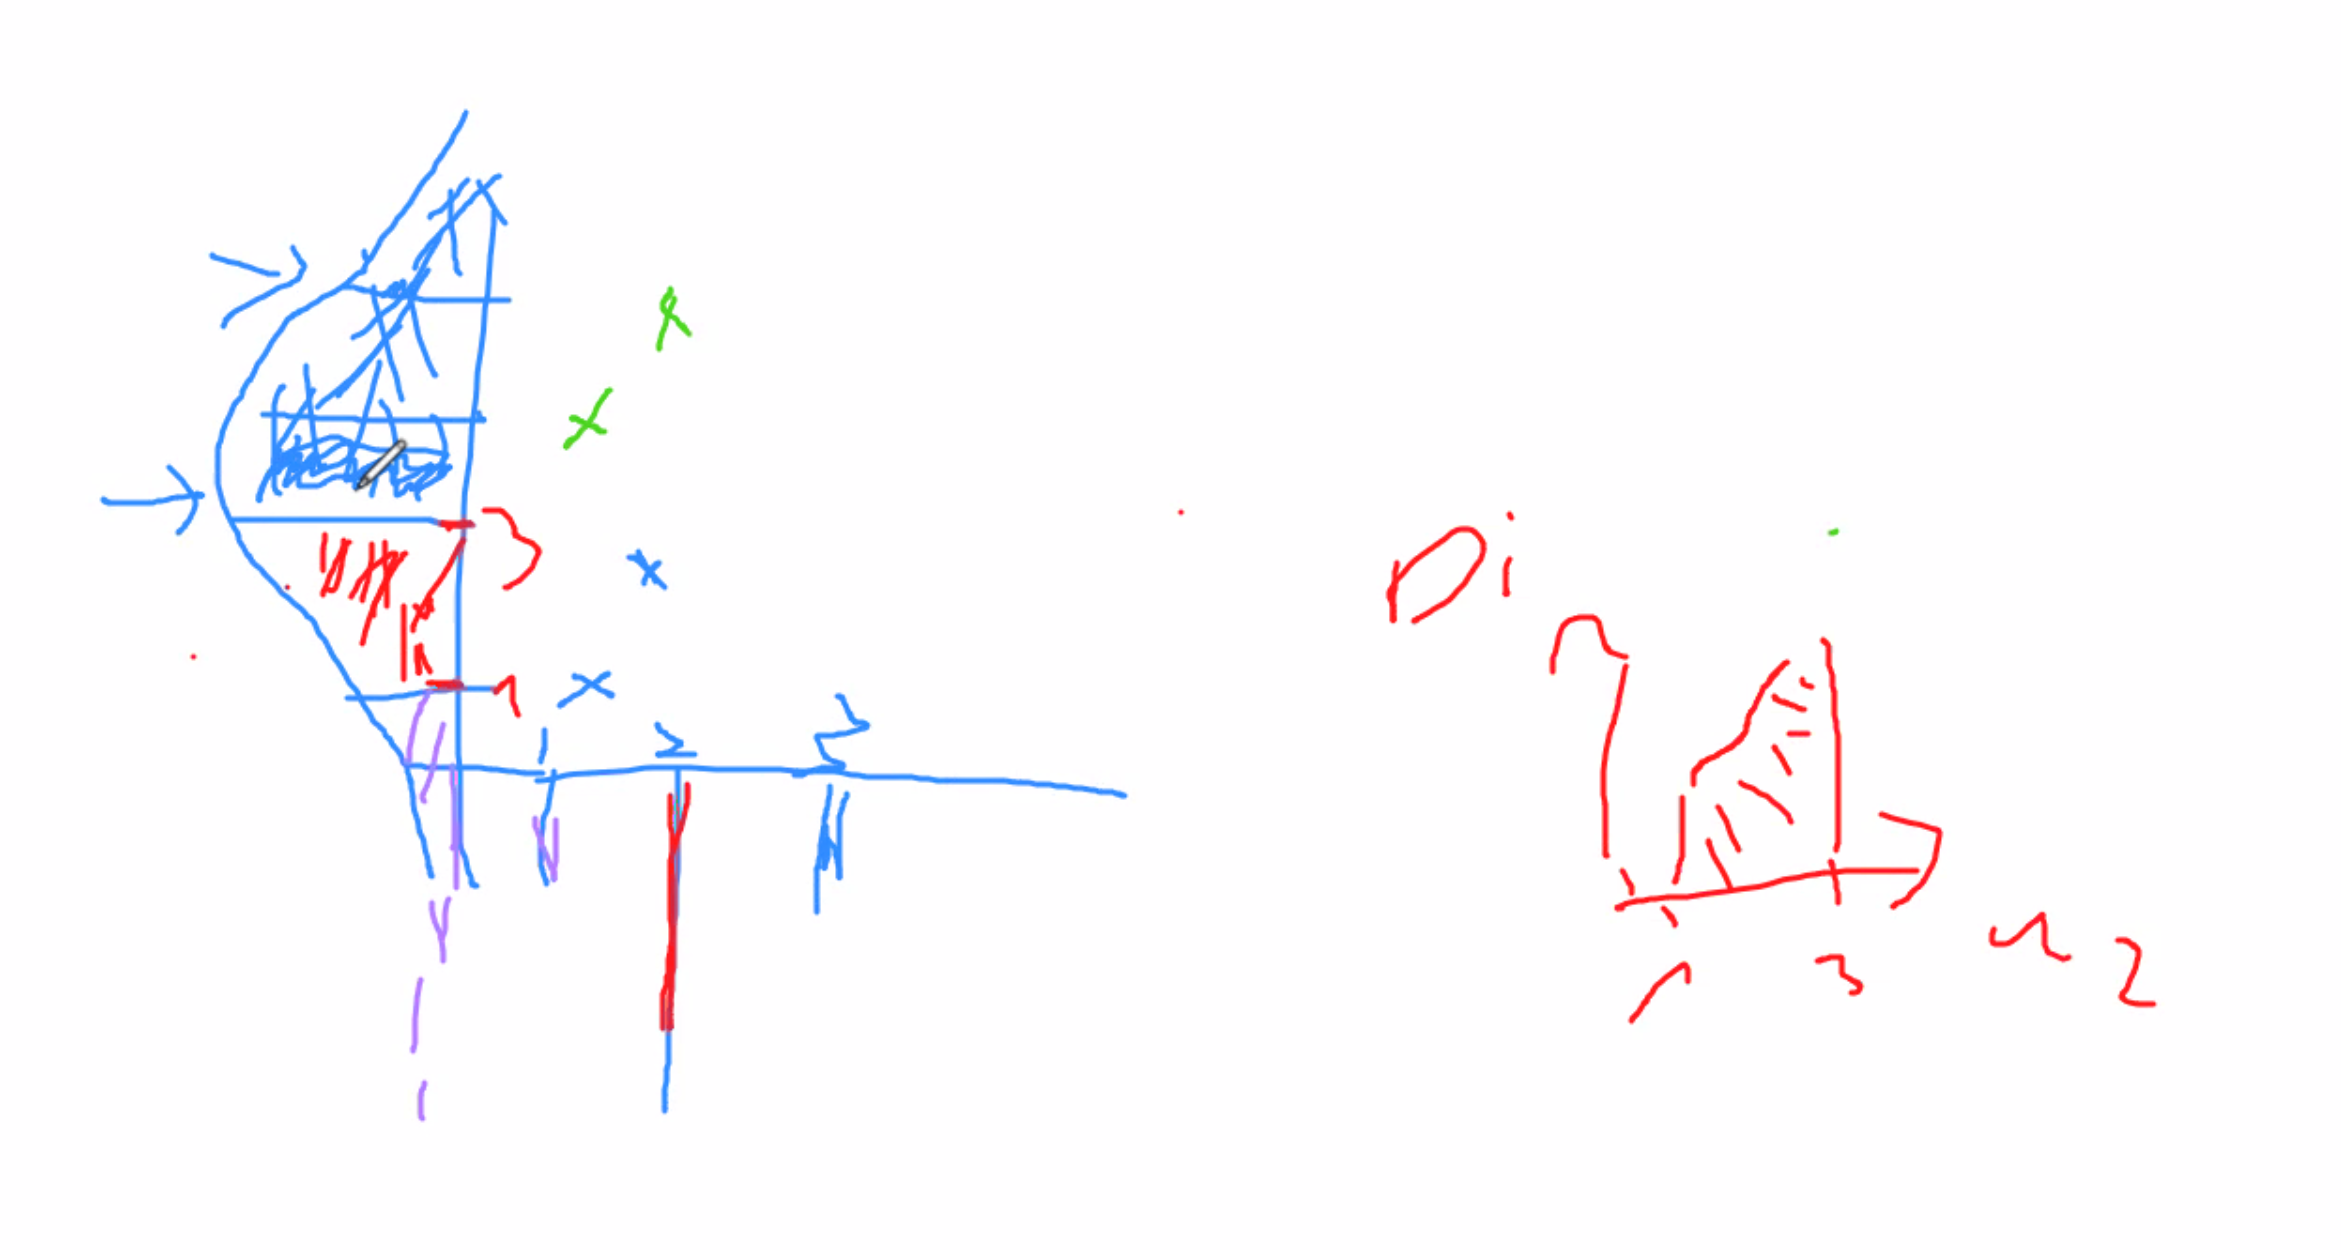